# Routine to interpolate sounding data to regular height interval for easier intercomparison over time


https://weather.uwyo.edu/upperair/sounding.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta

# meteorology - specific
from metpy.calc import relative_humidity_from_dewpoint
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

import sys
sys.path.append('./scripts/')

from LIB_dates import generate_date_list
from LIB_request_WUA_sounding import check_for_WUA_soundings
from LIB_sounding_analysis import interpolate_soundings

### Calculating relative humidity ($RH$, %) from $T$, $T_{d}$

Use [metpy.calc.relative_humidity_from_dewpoint(temperature, dewpoint)](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.relative_humidity_from_dewpoint.html) to calculate the relative humidity.
Uses temperature and dewpoint to calculate relative humidity as the ratio of vapor pressure to saturation vapor pressures.

$$RH = 100 \; \times \; \frac{e(T_{d})}{e_{s}(T)}$$

### Request [Wyoming Upper Air sounding](https://weather.uwyo.edu/upperair/sounding.html) data with [siphon](https://unidata.github.io/siphon/latest/examples/upperair/Wyoming_Request.html#sphx-glr-examples-upperair-wyoming-request-py)

In [2]:
# specify date and time (Z) and 
# station from which to request data
#================================
date = datetime(2022, 7, 1, 0)
station = 'PABR'
#================================

# request data using siphon
try:
    df = WyomingUpperAir.request_data(date, station)
    
except:
    df = []
    print(f"No data available for {date}")

    
# if data request was succesful:
# pull out T, Td, H and calculate RH
#-----------------------------------
if len(df) > 0:
    
    # assign units to all data
    height = df['height'].values * units(df.units['height']).to(units.kilometer)
    temperature = df['temperature'].values * units(df.units['temperature'])
    dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])

    # crop all to below 12 km
    H = height[height < 12*units.kilometer]
    T = temperature[height < 12*units.kilometer]
    Td = dewpoint[height < 12*units.kilometer]

    # calculate relative humidity
    RH = relative_humidity_from_dewpoint(T, Td).to('percent')
    
# interpolate 
#-----------------------------------    

In [3]:
[new_RH, new_T], new_H, edges = interpolate_soundings(variable = [RH, T], heights = H, bin_width = 0.25*units.kilometer, 
                          min_height = 0*units.kilometer, max_height = 12*units.kilometer, 
                          method = 'max', 
                          suppress_plots = True,
                          suppress_prints = True)

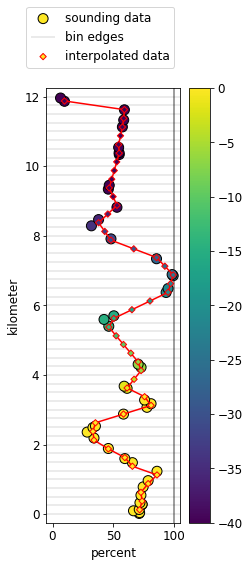

In [4]:
fig, ax = plt.subplots(figsize=(3, 8))
# ax.plot(RH, H, c='k', zorder=0)
temp = ax.scatter(RH, H, c=T, edgecolor='k', s=100, vmin=-40, vmax = 0, zorder=1, label='sounding data')
plt.colorbar(temp)

RH_thresh = 100
ax.vlines(RH_thresh,-1,20, colors='k', alpha=0.5, zorder=-1)

plt.xlim(-5,105)
plt.ylim(-0.25,12.25)


for edge in edges:
    ax.hlines(edge,-5, 105, colors='k', alpha=0.1, zorder=-1, label='bin edges')

ax.plot(new_RH, new_H, c='r', zorder=1)
ax.scatter(new_RH, new_H, c=new_T, edgecolor='r', marker='D', s=20, vmin=-40, vmax = 0, zorder=1, label='interpolated data')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1,1.2))

In [5]:
new_RH[new_H == 6.875*units.kilometer]

Magnitude,[99.10811543297663]
Units,percent


#### Reading in locally-stored University of Wyoming sounding data

In [6]:
# #========================================
# # number of data columns
# num_cols = 11

# # path to sounding file
# sound_txt = "./sound_jun.txt"

# # row where data starts (0 is first)
# row_ds = 5
# #========================================

# read_in_data = np.array([])

# # open text file
# with open(sound_txt) as file:
    
#     # run through all file rows
#     for ii, item in enumerate(file):
#         print(item)
        
#         # save data if after header rows
#         if ii >= row_ds:
            
#             # split data by spaces and save as floats
            
#             data_columns = [float(x) for x in item.split('\n')[0].split(' ') if x != '']
            
#             # save data if has length num_columns
#             # (don't save on pressure levels where not all variables are present)
#             if len(data_columns) == num_cols:
#                 read_in_data = np.append(read_in_data, data_columns)
            
# # reshape into array
# sounding_data = np.reshape(read_in_data, (int(len(read_in_data)/num_cols), num_cols))        